<a href="https://colab.research.google.com/github/yoonputer/Team_Project2/blob/master/Deeplearning/lotto_deeplearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# lotto

[동행복권사이트](https://dhlottery.co.kr/common.do?method=main)


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
!pip install tensorflow-gpu==2.0.0-rc1
!pip install 'h5py==2.10.0' --force-reinstall

##데이터불러오기

In [2]:
!ls ./drive/MyDrive/Forkspoon/lotto.csv

./drive/MyDrive/Forkspoon/lotto.csv


In [3]:
import numpy as np

rows = np.loadtxt("./drive/MyDrive/Forkspoon/lotto.csv", delimiter=",")
row_count = len(rows)
print(row_count)

976


## 원핫인코딩

In [4]:
import numpy as np

def numbers2ohbin(numbers):

    ohbin = np.zeros(45) 

    for i in range(6): 
        ohbin[int(numbers[i])-1] = 1 
    
    return ohbin

def ohbin2numbers(ohbin):

    numbers = []
    
    for i in range(len(ohbin)):
        if ohbin[i] == 1.0: 
            numbers.append(i+1)
    
    return numbers

In [5]:
numbers = rows[:, 1:7]
ohbins = list(map(numbers2ohbin, numbers))

x_samples = ohbins[0:row_count-1]
y_samples = ohbins[1:row_count]

print("ohbins")
print("X[0]: " + str(x_samples[0]))
print("Y[0]: " + str(y_samples[0]))

print("numbers")
print("X[0]: " + str(ohbin2numbers(x_samples[0])))
print("Y[0]: " + str(ohbin2numbers(y_samples[0])))

ohbins
X[0]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
Y[0]: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
numbers
X[0]: [10, 23, 29, 33, 37, 40]
Y[0]: [9, 13, 21, 25, 32, 42]


## 데이터 구성 - 훈련셋/ 검증셋/ 시험셋 분리

훈련셋(800개): (1회 입력, 2회 출력)~(800회 입력, 801회 출력)

검증셋(100개): (801회,802회)~(900회,901회)

시험셋(65개): (901회,902회)~(965회,966회)

In [6]:
train_idx = (0, 800)
val_idx = (801, 900)
test_idx = (901, len(x_samples))

print("train: {0}, val: {1}, test: {2}".format(train_idx, val_idx, test_idx))

train: (0, 800), val: (801, 900), test: (901, 975)


## 모델-LSTM

시계열 데이터, 자연어 데이터 처리 등에 사용되는 딥러닝 모델

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models


model = keras.Sequential([
    keras.layers.LSTM(128, batch_input_shape=(1, 1, 45), return_sequences=False, stateful=True),
    keras.layers.Dense(45, activation='sigmoid')
])


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:

train_loss = []
train_acc = []
val_loss = []
val_acc = []


for epoch in range(100):

    model.reset_states() 

    batch_train_loss = []
    batch_train_acc = []
    
    for i in range(train_idx[0], train_idx[1]):
        
        xs = x_samples[i].reshape(1, 1, 45)
        ys = y_samples[i].reshape(1, 45)
        
        loss, acc = model.train_on_batch(xs, ys) 

        batch_train_loss.append(loss)
        batch_train_acc.append(acc)

    train_loss.append(np.mean(batch_train_loss))
    train_acc.append(np.mean(batch_train_acc))

    batch_val_loss = []
    batch_val_acc = []

    for i in range(val_idx[0], val_idx[1]):

        xs = x_samples[i].reshape(1, 1, 45)
        ys = y_samples[i].reshape(1, 45)
        
        loss, acc = model.test_on_batch(xs, ys) 
        
        batch_val_loss.append(loss)
        batch_val_acc.append(acc)

    val_loss.append(np.mean(batch_val_loss))
    val_acc.append(np.mean(batch_val_acc))

    print('epoch {0:4d} train acc {1:0.3f} loss {2:0.3f} val acc {3:0.3f} loss {4:0.3f}'.format(epoch, np.mean(batch_train_acc), np.mean(batch_train_loss), np.mean(batch_val_acc), np.mean(batch_val_loss)))

```
...
epoch   96 train acc 0.997 loss 0.016 val acc 0.803 loss 1.198
epoch   97 train acc 0.996 loss 0.017 val acc 0.810 loss 1.175
epoch   98 train acc 0.997 loss 0.014 val acc 0.815 loss 1.169
epoch   99 train acc 0.999 loss 0.010 val acc 0.809 loss 1.178
```

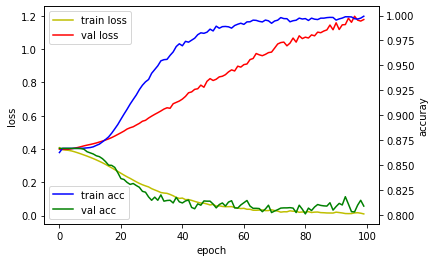

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(train_loss, 'y', label='train loss')
loss_ax.plot(val_loss, 'r', label='val loss')

acc_ax.plot(train_acc, 'b', label='train acc')
acc_ax.plot(val_acc, 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

## 예측한 번호로 상금 얼마나 받을 수 있을까?

In [10]:
mean_prize = [ np.mean(rows[87:, 8]),
           np.mean(rows[87:, 9]),
           np.mean(rows[87:, 10]),
           np.mean(rows[87:, 11]),
           np.mean(rows[87:, 12])]

print(mean_prize)

[2432962447.5174356, 57212654.51631046, 1451009.0967379077, 52779.50281214848, 5000.0]


In [11]:
def calc_reward(true_numbers, true_bonus, pred_numbers):

    count = 0

    for ps in pred_numbers:
        if ps in true_numbers:
            count += 1

    if count == 6:
        return 0, mean_prize[0]
    elif count == 5 and true_bonus in pred_numbers:
        return 1, mean_prize[1]
    elif count == 5:
        return 2, mean_prize[2]
    elif count == 4:
        return 3, mean_prize[3]
    elif count == 3:
        return 4, mean_prize[4]

    return 5, 0

In [12]:
def gen_numbers_from_probability(nums_prob):

    ball_box = []

    for n in range(45):
        ball_count = int(nums_prob[n] * 100 + 1)
        ball = np.full((ball_count), n+1) #1부터 시작
        ball_box += list(ball)

    selected_balls = []

    while True:
        
        if len(selected_balls) == 6:
            break
        
        ball_index = np.random.randint(len(ball_box), size=1)[0]
        ball = ball_box[ball_index]

        if ball not in selected_balls:
            selected_balls.append(ball)

    return selected_balls

In [ ]:
train_total_reward = []
train_total_grade = np.zeros(6, dtype=int)

val_total_reward = []
val_total_grade = np.zeros(6, dtype=int)

test_total_reward = []
test_total_grade = np.zeros(6, dtype=int)

model.reset_states()

print('[No. ] 1st 2nd 3rd 4th 5th 6th Rewards')

for i in range(len(x_samples)):
    xs = x_samples[i].reshape(1, 1, 45)
    ys_pred = model.predict_on_batch(xs) 
    
    sum_reward = 0
    sum_grade = np.zeros(6, dtype=int)

    for n in range(10): 
        numbers = gen_numbers_from_probability(ys_pred[0])
        
       
        grade, reward = calc_reward(rows[i+1,1:7], rows[i+1,7], numbers) 
        
        sum_reward += reward
        sum_grade[grade] += 1

        if i >= train_idx[0] and i < train_idx[1]:
            train_total_grade[grade] += 1
        elif i >= val_idx[0] and i < val_idx[1]:
            val_total_grade[grade] += 1
        elif i >= test_idx[0] and i < test_idx[1]:
            val_total_grade[grade] += 1
    
    if i >= train_idx[0] and i < train_idx[1]:
        train_total_reward.append(sum_reward)
    elif i >= val_idx[0] and i < val_idx[1]:
        val_total_reward.append(sum_reward)
    elif i >= test_idx[0] and i < test_idx[1]:
        test_total_reward.append(sum_reward)
                        
    print('[{0:4d}] {1:3d} {2:3d} {3:3d} {4:3d} {5:3d} {6:3d} {7:15,d}'.format(i+1, sum_grade[0], sum_grade[1], sum_grade[2], sum_grade[3], sum_grade[4], sum_grade[5], int(sum_reward)))

print('Total') 
print('==========')    
print('Train {0:5d} {1:5d} {2:5d} {3:5d} {4:5d} {5:5d} {6:15,d}'.format(train_total_grade[0], train_total_grade[1], train_total_grade[2], train_total_grade[3], train_total_grade[4], train_total_grade[5], int(sum(train_total_reward))))
print('Val   {0:5d} {1:5d} {2:5d} {3:5d} {4:5d} {5:5d} {6:15,d}'.format(val_total_grade[0], val_total_grade[1], val_total_grade[2], val_total_grade[3], val_total_grade[4], val_total_grade[5], int(sum(val_total_reward))))
print('Test  {0:5d} {1:5d} {2:5d} {3:5d} {4:5d} {5:5d} {6:15,d}'.format(test_total_grade[0], test_total_grade[1], test_total_grade[2], test_total_grade[3], test_total_grade[4], test_total_grade[5], int(sum(test_total_reward))))
print('==========')

```
[No. ] 1st 2nd 3rd 4th 5th 6th Rewards
[   1]   4   0   4   2   0   0   9,737,759,385
[   2]   4   0   5   1   0   0   9,739,157,615
[   3]   4   0   5   1   0   0   9,739,157,615
[   4]   3   0   5   1   1   0   7,306,200,167
[   5]   2   0   7   1   0   0   4,876,134,738
[   6]   2   0   7   1   0   0   4,876,134,738
[   7]   1   0   7   1   1   0   2,443,177,290
[   8]   3   0   5   2   0   0   7,306,247,947
[   9]   1   1   4   2   2   0   2,496,094,697
[  10]   4   0   3   3   0   0   9,736,361,155
[  11]   1   0   8   1   0   0   2,444,623,299
[  12]   3   2   1   4   0   0   7,414,974,778
[  13]   2   0   6   1   1   0   4,874,688,729
[  14]   4   0   4   2   0   0   9,737,759,385
[  15]   4   1   3   2   0   0   9,793,521,030
[  16]   3   0   5   1   1   0   7,306,200,167
[  17]   1   0   6   2   1   0   2,441,779,061
[  18]   2   0   7   1   0   0   4,876,134,738
[  19]   3   0   4   3   0   0   7,304,849,717
[  20]   2   0   7   1   0   0   4,876,134,738
[  21]   3   1   3   3   0   0   7,360,611,362
[  22]   2   0   6   2   0   0   4,874,736,508
[  23]   2   0   8   0   0   0   4,877,532,967
[  24]   6   0   3   1   0   0  14,602,180,491
[  25]   3   0   5   2   0   0   7,306,247,947
[  26]   5   0   2   3   0   0  12,167,872,594
[  27]   3   1   4   1   1   0   7,361,961,812
[  28]   2   0   5   3   0   0   4,873,338,279
[  29]   4   0   5   1   0   0   9,739,157,615
[  30]   3   0   4   2   1   0   7,304,801,937
[  31]   3   0   4   2   1   0   7,304,801,937
[  32]   3   0   5   2   0   0   7,306,247,947
...

[ 970]   0   0   0   0   0  10               0
[ 971]   0   0   0   0   0  10               0
[ 972]   0   0   0   0   0  10               0
[ 973]   0   0   0   0   0  10               0
[ 974]   0   0   0   0   1   9           5,000
[ 975]   0   0   0   0   2   8          10,000
Total
==========
Train  2599   112  3791  1309   179    10 6,335,247,977,258
Val       0     0     0     0    47  1683         150,000
Test      0     0     0     0     0     0          85,000
==========
```

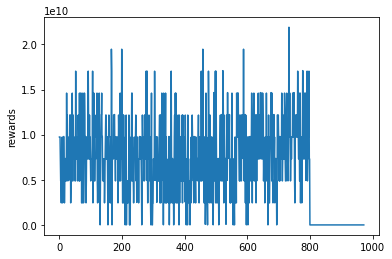

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

total_reward = train_total_reward + val_total_reward + test_total_reward

plt.plot(total_reward)
plt.ylabel('rewards')
plt.show()

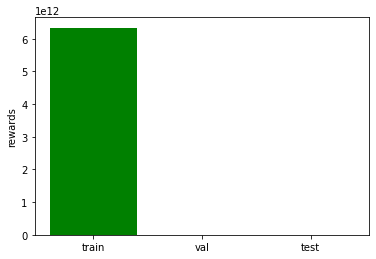

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

rewards = [sum(train_total_reward), sum(val_total_reward), sum(test_total_reward)]

class_color=['green', 'blue', 'red']

plt.bar(['train', 'val', 'test'], rewards, color=class_color)
plt.ylabel('rewards')
plt.show()

In [ ]:

for epoch in range(100):

    model.reset_states()

    for i in range(len(x_samples)):
        
        xs = x_samples[i].reshape(1, 1, 45)
        ys = y_samples[i].reshape(1, 45)
        
        loss, acc = model.train_on_batch(xs, ys)

        batch_train_loss.append(loss)
        batch_train_acc.append(acc)

    train_loss.append(np.mean(batch_train_loss))
    train_acc.append(np.mean(batch_train_acc))

    print('epoch {0:4d} train acc {1:0.3f} loss {2:0.3f}'.format(epoch, np.mean(batch_train_acc), np.mean(batch_train_loss)))

```
...
epoch   86 train acc 0.992 loss 0.032
epoch   87 train acc 0.992 loss 0.032
epoch   88 train acc 0.992 loss 0.032
epoch   89 train acc 0.992 loss 0.032
epoch   90 train acc 0.992 loss 0.031
epoch   91 train acc 0.992 loss 0.031
epoch   92 train acc 0.992 loss 0.031
epoch   93 train acc 0.992 loss 0.031
epoch   94 train acc 0.992 loss 0.030
epoch   95 train acc 0.992 loss 0.030
epoch   96 train acc 0.992 loss 0.030
epoch   97 train acc 0.992 loss 0.030
epoch   98 train acc 0.992 loss 0.030
epoch   99 train acc 0.993 loss 0.029

```

In [17]:
print('receive numbers')

xs = x_samples[-1].reshape(1, 1, 45)

ys_pred = model.predict_on_batch(xs)

list_numbers = []

for n in range(10):
    numbers = gen_numbers_from_probability(ys_pred[0])
    numbers.sort()
    print('{0} : {1}'.format(n, numbers))
    list_numbers.append(numbers)

receive numbers
0 : [1, 13, 14, 15, 16, 35]
1 : [1, 14, 16, 28, 34, 41]
2 : [13, 14, 16, 28, 34, 35]
3 : [13, 16, 28, 34, 35, 41]
4 : [1, 16, 28, 34, 35, 41]
5 : [13, 15, 28, 34, 35, 41]
6 : [1, 16, 28, 34, 35, 41]
7 : [3, 28, 32, 34, 35, 41]
8 : [13, 16, 28, 34, 35, 41]
9 : [1, 13, 16, 28, 29, 34]


참조)

[딥러닝 로또 예측 번호 확인](https://animalface.site/lotto)

[동영상 설명: 유튜브 조코딩 채널](https://www.youtube.com/channel/UCQNE2JmbasNYbjGAcuBiRRg)

[참고 문헌: 김태영님 블로그](https://tykimos.github.io/2020/01/25/keras_lstm_lotto_v895/)